# Model Data

Whenever you install photochem with `conda`, an additional packaged called `photochem_clima_data` is also installed. This package contains all the data that photochem needs to do photochemical and climate calculations

In [1]:
from photochem_clima_data import DATA_DIR
print(DATA_DIR)

/Users/nicholas/mambaforge/envs/workshop/lib/python3.12/site-packages/photochem_clima_data/data


`DATA_DIR` is the directory with all the model data. Below we copy this data to our current folder

In [2]:
import shutil, os
if os.path.isdir('./data_copy'):
    shutil.rmtree('./data_copy')
_ = shutil.copytree(DATA_DIR, './data_copy')

Lets take a look at some photolysis cross sections, which are stored in hdf5 files. The structure of each hdf5 file is as follows. Here I use `CO2.h5` as an example.

```yaml
wavelengths: Wavelengths in nm
photoabsorption: Total photoabsorption cross section in cm^2/molecule
photodissociation: Photodissociation cross section in cm^2/molecule
photoionisation: Photoionization cross section in cm^2/molecule
photodissociation-qy:
  wavelengths: Wavelengths for which quantum yields are defined
  CO2 + hv => CO + O: Quantum yields for the CO + O branch
  CO2 + hv => CO + O1D: Quantum yields for the CO + O1D branch
```

All arrays are 32 bit floats. The data assumes that cross sections are zero beyond the edges of the specified wavelengths. Quantum yields, on the other hand, should be constantly extrapolated.

In [3]:
import h5py
import yaml
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})

xs = {}
with h5py.File('data_copy/xsections/CO2.h5','r') as f:
    xs['wv'] = f['wavelengths'][:]
    xs['xsp'] = f['photodissociation'][:]
    xs['xsa'] = f['photoabsorption'][:]
    xs['xsi'] = f['photoionisation'][:]

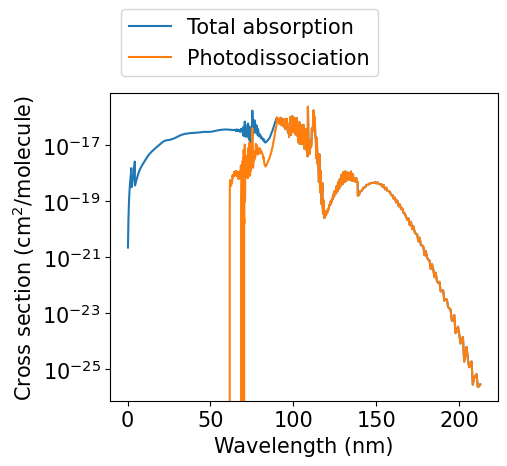

In [4]:
fig,ax = plt.subplots(1,1,figsize=[5,4])
ax.plot(xs['wv'], xs['xsa'], label='Total absorption')
ax.plot(xs['wv'], xs['xsp'], label='Photodissociation')

ax.set_yscale('log')
ax.set_ylabel('Cross section (cm$^2$/molecule)')
ax.set_xlabel('Wavelength (nm)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
plt.show()

Now, we can print the quantum yields:

In [5]:
qy = {}
with h5py.File('data_copy/xsections/CO2.h5','r') as f:
    b = f['photodissociation-qy']
    qy['wv'] = b['wavelengths'][:]
    for key in b:
        if key != 'wavelengths':
            qy[key] = b[key][:]

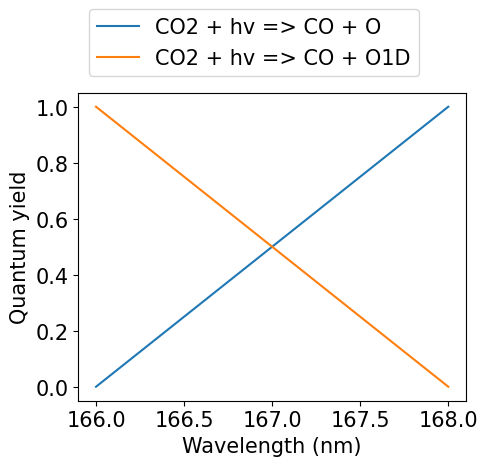

In [6]:
fig,ax = plt.subplots(1,1,figsize=[5,4])

for key in qy:
    if key != 'wv':
        ax.plot(qy['wv'], qy[key], label=key)

ax.set_ylabel('Quantum yield')
ax.set_xlabel('Wavelength (nm)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
plt.show()

Above, the quantum yields are assumed to be extrapolated beyond the specified wavelengths.

The citations for each cross section are given in `metadata.yaml`, with citations in `bib.bib`

## Modifying a cross section

Below, we show how to modify a cross section. Here, we just increase the photolysis cross section for CO$_2$ by a factor of 10:

In [7]:
from copy import deepcopy

xs_new = deepcopy(xs)
for key in xs_new:
    if key != 'wv':
        xs_new[key] *= 10

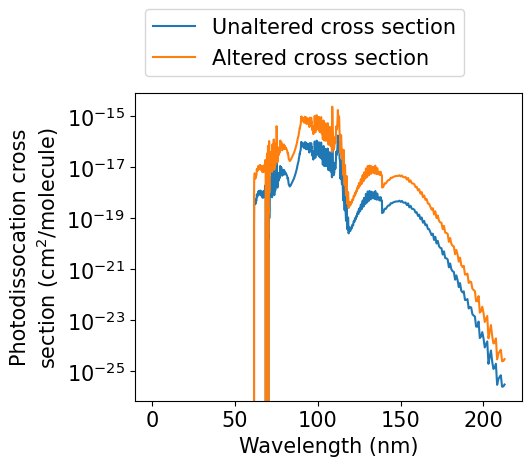

In [8]:
fig,ax = plt.subplots(1,1,figsize=[5,4])

ax.plot(xs['wv'], xs['xsp'], label='Unaltered cross section')
ax.plot(xs_new['wv'], xs_new['xsp'], label='Altered cross section')

ax.set_yscale('log')
ax.set_ylabel('Photodissocation cross\nsection (cm$^2$/molecule)')
ax.set_xlabel('Wavelength (nm)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
plt.show()

Next, we overwrite the `CO2.h5` file in our copy of the model data (`data_copy/xsections/`)

In [9]:
def check_xs_and_qy(xs, qy):

    # Check to make sure that QYs sum to 1
    if qy is not None:
        qyt = np.zeros(qy['wv'].shape[0])
        for eq in qy:
            if eq != 'wv': 
                qyt += qy[eq]
        assert np.all(np.isclose(qyt ,1,rtol=1e-3))

    # Make sure absorption is never less than the sum of ionoization and photolysis
    # To within a tolerance
    assert np.all(xs['xsa']*(1+1e-3) >= xs['xsp'] + xs['xsi'])

    # Must be sorted
    wv = xs['wv'].astype(np.float32)
    assert np.all(wv[:-1] < wv[1:])

    if qy is not None:
        wv = qy['wv'].astype(np.float32)
        assert np.all(wv[:-1] < wv[1:])

def make_xs_h5_file(outfilename, xs, qy=None):

    # Checks for problems with cross sections
    check_xs_and_qy(xs, qy)
    
    with h5py.File(outfilename,'w') as f:
        dset = f.create_dataset("wavelengths", xs['wv'].shape, 'f')
        dset[:] = xs['wv']

        dset = f.create_dataset("photoabsorption", xs['xsa'].shape, 'f')
        dset[:] = xs['xsa']

        dset = f.create_dataset("photodissociation", xs['xsp'].shape, 'f')
        dset[:] = xs['xsp']

        dset = f.create_dataset("photoionisation", xs['xsi'].shape, 'f')
        dset[:] = xs['xsi']

        if qy is not None:
            grp = f.create_group("photodissociation-qy")

            dset = grp.create_dataset("wavelengths", qy['wv'].shape, 'f')
            dset[:] = qy['wv']
            
            for eq in qy:
                if eq != 'wv':
                    dset = grp.create_dataset(eq, qy[eq].shape, 'f')
                    dset[:] = qy[eq]   

# Make the new file, overwriting the one in "data_copy"
make_xs_h5_file('data_copy/xsections/CO2.h5', xs_new, qy)

To use the cross section with the photochemical model, initialize the code with the `data_dir` argument set to your new, modified copy of the data:

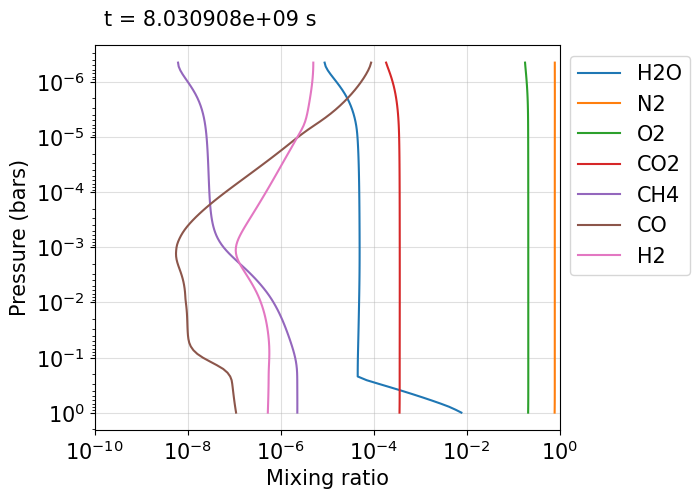

In [10]:
from photochem import EvoAtmosphere, zahnle_earth
from utils import find_steady_state

pc = EvoAtmosphere(
    zahnle_earth,
    'input/settings.yaml',
    'input/Sun_now.txt',
    'input/atmosphere.txt',
    data_dir='data_copy'
)
pc.var.verbose=0

find_steady_state(pc)

The photochemical model depends on a lot more data than just photolysis cross sections. Modifying those data follow the same principles as above:

1. Make a copy of all of `photochem_clima_data.DATA_DIR`
2. Modify the files within that copied directory
3. Initialize the photochemical model, pointing the code to this new modified data directory.